In [1]:
import numpy as np  
from sklearn.datasets import load_files  
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import shap
shap.initjs()

In [2]:
categories = ["soil", "sediment", "marine", "freshwater"]
#categories = ["bioreactor", "sediment", "freshwater"]
habitat_data = load_files(r"/home/sih13/Downloads/ebi_sentiment_txt", categories=categories)  
X, y, target_name = habitat_data.data, habitat_data.target, habitat_data.target_names

In [3]:
target_name

['freshwater', 'marine', 'sediment', 'soil']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
tfidf = TfidfVectorizer()
xgb = XGBClassifier(nthread=8)

#clf = make_pipeline(TfidfVectorizer(max_features=100, min_df=5, max_df=0.7), XGBClassifier())

pipe = Pipeline(steps=[('tfidf', tfidf), ('xgb', xgb)])

In [6]:
param_grid = {
    'tfidf__max_features': [120],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.7],
    'xgb__max_depth': [9],
    'xgb__subsample': [0.6]
}

In [7]:
#Best parameter (CV score=0.978):
#{'tfidf__max_df': 0.7, 'tfidf__max_features': 80, 'tfidf__min_df': 2, 'xgb__max_depth': 9, 'xgb__subsample': 0.6}

#param_grid = {
#    'tfidf__max_features': [30, 80],
#    'tfidf__min_df': [2, 8],
#    'tfidf__max_df': [0.5, 0.7],
#    'xgb__max_depth': [9],
#    'xgb__subsample': [0.6]
#}

In [8]:
clf = GridSearchCV(pipe, param_grid)
clf.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Best parameter (CV score=0.980):
{'tfidf__max_df': 0.7, 'tfidf__max_features': 120, 'tfidf__min_df': 2, 'xgb__max_depth': 9, 'xgb__subsample': 0.6}


In [9]:
y_pred = clf.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred, target_names=target_name))
print(confusion_matrix(y_test, y_pred, labels=range(len(target_name))))

              precision    recall  f1-score   support

  freshwater       0.95      0.93      0.94      1460
      marine       0.99      0.99      0.99      8112
    sediment       0.96      0.77      0.85        90
        soil       0.99      0.99      0.99      3451

    accuracy                           0.98     13113
   macro avg       0.97      0.92      0.94     13113
weighted avg       0.98      0.98      0.98     13113

[[1363   71    0   26]
 [  44 8050    3   15]
 [   9    8   69    4]
 [  24   20    0 3407]]


In [11]:
best_pipe = clf.best_estimator_
best_model = best_pipe.named_steps["xgb"]
best_tfidfconverter = best_pipe.named_steps["tfidf"]

In [12]:
X_test_df = pd.DataFrame.sparse.from_spmatrix(best_tfidfconverter.transform(X_test))
X_test_df.columns = best_tfidfconverter.get_feature_names()

X_train_df = pd.DataFrame.sparse.from_spmatrix(best_tfidfconverter.transform(X_train))
X_train_df.columns = best_tfidfconverter.get_feature_names()


#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0,:])



In [62]:
X_train_summary = shap.kmeans(X_train_df, 300)
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_summary)
shap_values = explainer.shap_values(X_test_df[:100])

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [08:57<00:00,  5.38s/it]


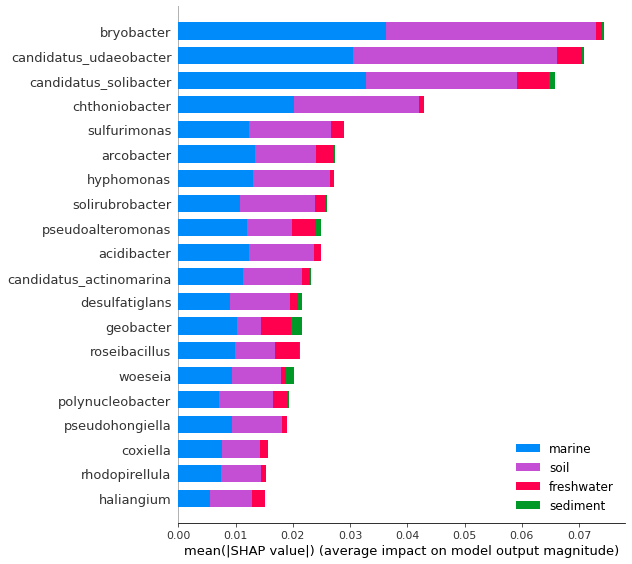

In [63]:
shap.summary_plot(
            shap_values, X_test_df[:100], class_names=target_name
 )

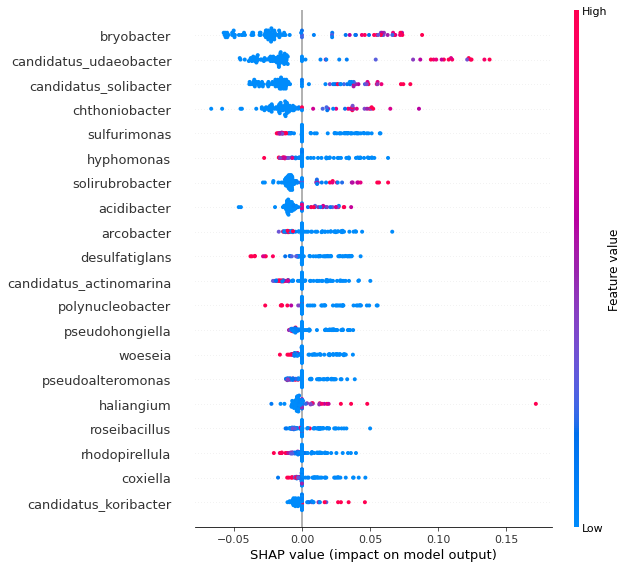

In [70]:
shap.summary_plot(shap_values[3], X_test_df[:100])

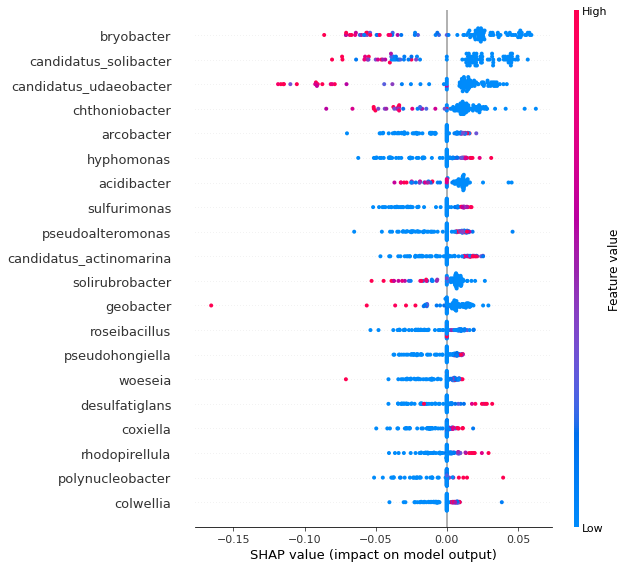

In [75]:
shap.summary_plot(shap_values[1], X_test_df[:100])

In [16]:
y_test[:20]

array([3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3])

In [17]:
y_pred[:20]

array([3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3])

In [51]:
row = 19

for i in range(len(target_name)):
    display(shap.force_plot(explainer.expected_value[i], shap_values[i][row], X_test_df.iloc[row]))


In [50]:
shap.force_plot(explainer.expected_value[3], shap_values[3][0:20], X_test_df.iloc[0:20])

In [40]:

feature_importances = pd.DataFrame(best_model.feature_importances_,
                                   index = best_tfidfconverter.get_feature_names(),
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

,importance
candidatus_solibacter,0.151793
bryobacter,0.135942
sediminibacterium,0.068705
mortierella,0.044103
polynucleobacter,0.030439
karlodinium,0.022733
pseudoalteromonas,0.022566
candidatus_actinomarina,0.022247
roseibacillus,0.020406
paracalanus,0.020051


In [41]:
import seaborn as sns

def violinplot_taxon(X, y, taxon):

    y_label = target_name

    target_column = best_tfidfconverter.get_feature_names().index(taxon)

    temp = []
    labels = []

    for i in range(len(X)):
        temp.append(X.iloc[i][target_column])
        labels.append(y_label[y[i]])


    temp_df = pd.DataFrame.from_dict({taxon: temp, "habitat": labels})


    ax = sns.violinplot(x="habitat", y=taxon, cut = 0, data=temp_df)



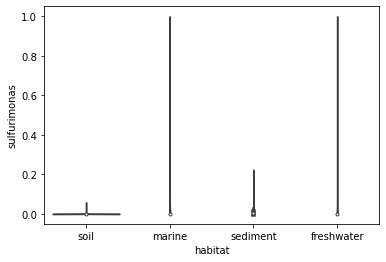

In [71]:
violinplot_taxon(X_test_df, y_test, "sulfurimonas")